Enabling and testing the GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Observe TensorFlow speedup on GPU relative to CPU

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  

cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.0040476260001014
GPU (s):
0.0351261780006098
GPU speedup over CPU: 85x


Install library Keras for  save model.h5

In [3]:
!pip install pyyaml h5py 

instal library Matplotlib

In [4]:
!pip install matplotlib-venn

Pre-Train Dataset

In [5]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
print(tf.__version__)
from tqdm import tqdm
from random import shuffle
from tensorflow.keras.utils  import to_categorical
import pickle

!wget --no-check-certificate \
    https://storage.googleapis.com/dataset_fresh_rotten_eldho/fruits-fresh-and-rotten-for-classification.zip \
    -O /tmp/fruits-fresh-and-rotten-for-classification.zip
    
local_zip = '/tmp/fruits-fresh-and-rotten-for-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

2.5.0
--2021-06-06 07:13:54--  https://storage.googleapis.com/dataset_fresh_rotten_eldho/fruits-fresh-and-rotten-for-classification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3845474308 (3.6G) [application/zip]
Saving to: ‘/tmp/fruits-fresh-and-rotten-for-classification.zip’

/tmp/fruits-fresh-a 100%[===================>]   3.58G  40.6MB/s    in 65s     

2021-06-06 07:15:00 (56.2 MB/s) - ‘/tmp/fruits-fresh-and-rotten-for-classification.zip’ saved [3845474308/3845474308]



Load Dataset for Train

In [6]:
def load_rand():
    X=[]
    dir_path='/tmp/dataset/train'
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(50,50))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X
    

Show Dataset on Training

In [7]:
X=load_rand()

100%|██████████| 6/6 [00:00<00:00, 52.89it/s]

rottenoranges
freshoranges
rottenapples
rottenbanana
freshbanana
freshapples


In [8]:
X=np.array(X)
X.shape

(36, 50, 50, 3)

In [9]:
def show_subpot(X,title=False,Y=None):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(50,50))
        list_fruits=['rottenoranges', 'freshoranges','rottenapples', 'rottenbanana', 'freshbanana', 'freshapples']
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            if title==False:
                ax[i//6][i%6].set_title(list_fruits[i//6])
            elif title and Y is not None:
                ax[i//6][i%6].set_title(Y[i])
        plt.show()
    else:
        print('Cannot plot')

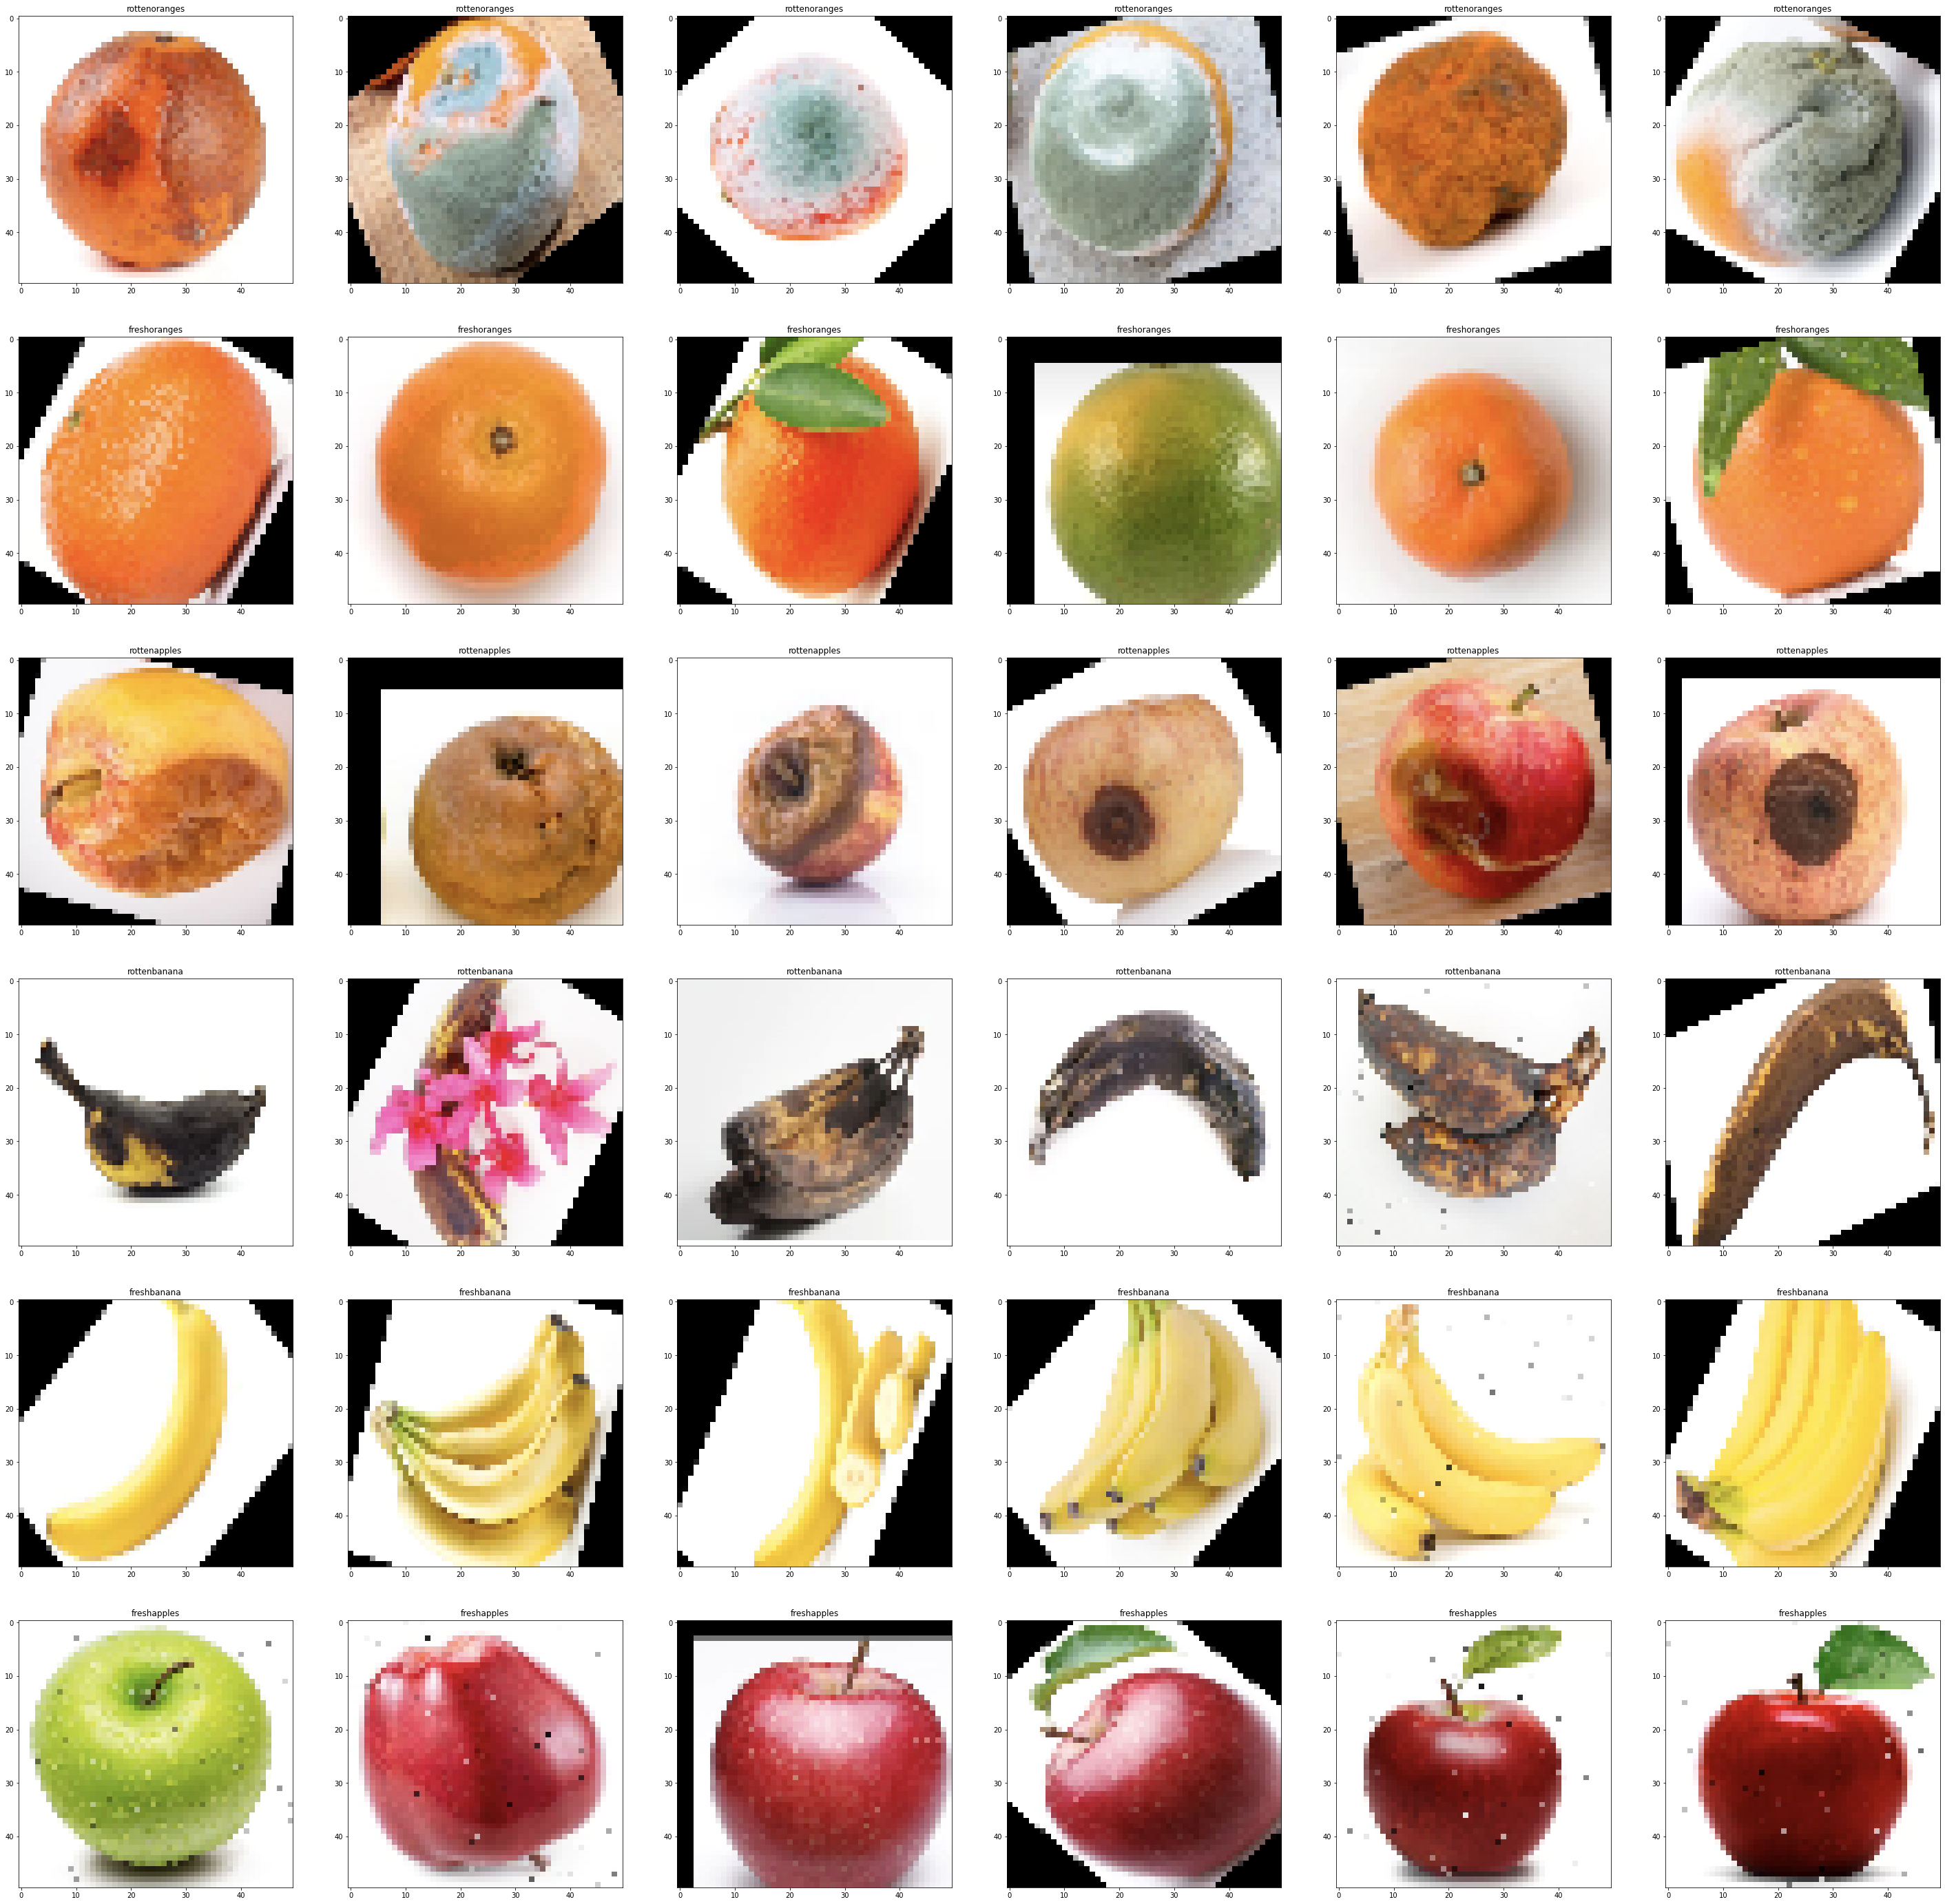

In [10]:
show_subpot(X)

In [11]:
def load_rottenvsfreshfruit():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/tmp/dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('/tmp/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('/tmp/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [12]:
X,Y=load_rottenvsfreshfruit()

100%|██████████| 10901/10901 [00:00<00:00, 1237471.80it/s]

Shuffling your data.....


In [16]:
Y=np.array(Y)
X=np.array(X)

In [17]:
def load_rottenvsfreshfruit_valset():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/tmp/dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('/tmp/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0]) 
        else:
            path_main=os.path.join('/tmp/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y            

In [18]:
X_val,Y_val=load_rottenvsfreshfruit_valset()

100%|██████████| 2698/2698 [00:00<00:00, 590217.09it/s]

Shuffling your data.....


In [19]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

Training Dataset

In [20]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [22]:
saved_model_path = "./rotten.h5"
model.save(saved_model_path)

In [23]:
import tensorflow as tf

In [24]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/rotten.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
X=X/255.0
X_val=X_val/255.0

In [26]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 10,
                 callbacks=[check_point])

Epoch 1/10
546/546 [==============================] - 50s 57ms/step - loss: 0.6937 - accuracy: 0.7805 - val_loss: 1.2348 - val_accuracy: 0.8247

Epoch 00001: val_loss improved from inf to 1.23483, saving model to /content/rotten.h5
Epoch 2/10
546/546 [==============================] - 30s 55ms/step - loss: 0.2580 - accuracy: 0.8996 - val_loss: 0.1543 - val_accuracy: 0.9411

Epoch 00002: val_loss improved from 1.23483 to 0.15431, saving model to /content/rotten.h5
Epoch 3/10
546/546 [==============================] - 30s 55ms/step - loss: 0.1861 - accuracy: 0.9348 - val_loss: 0.1536 - val_accuracy: 0.9537

Epoch 00003: val_loss improved from 0.15431 to 0.15359, saving model to /content/rotten.h5
Epoch 4/10
546/546 [==============================] - 30s 55ms/step - loss: 0.1227 - accuracy: 0.9533 - val_loss: 0.1442 - val_accuracy: 0.9325

Epoch 00004: val_loss improved from 0.15359 to 0.14422, saving model to /content/rotten.h5
Epoch 5/10
546/546 [==============================] - 30s 55

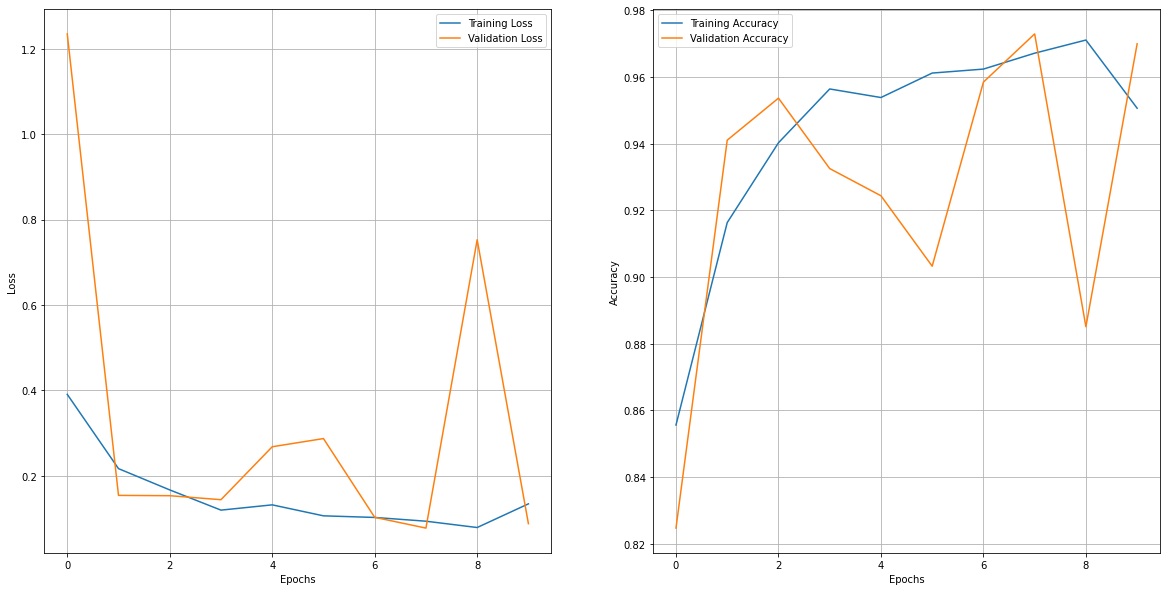

In [27]:
plt.figure(1, figsize = (20, 10))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [28]:
model.evaluate(X_val,Y_val)

85/85 [==============================] - 1s 12ms/step - loss: 0.0881 - accuracy: 0.9700


[0.0881221815943718, 0.9699777364730835]

In [29]:
model.save('/content/rottenfresh.h5')

In [30]:
from keras.models import Model, load_model

In [31]:
new_model=load_model('/content/rottenfresh.h5')

In [32]:
new_model.evaluate(X_val,Y_val)

85/85 [==============================] - 2s 11ms/step - loss: 0.0881 - accuracy: 0.9700


[0.0881221815943718, 0.9699777364730835]

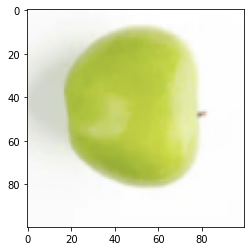

In [36]:
plt.imshow(X_val[10])

In [37]:
model.predict(X_val[10].reshape(1,100,100,3))

array([[0.06075582]], dtype=float32)

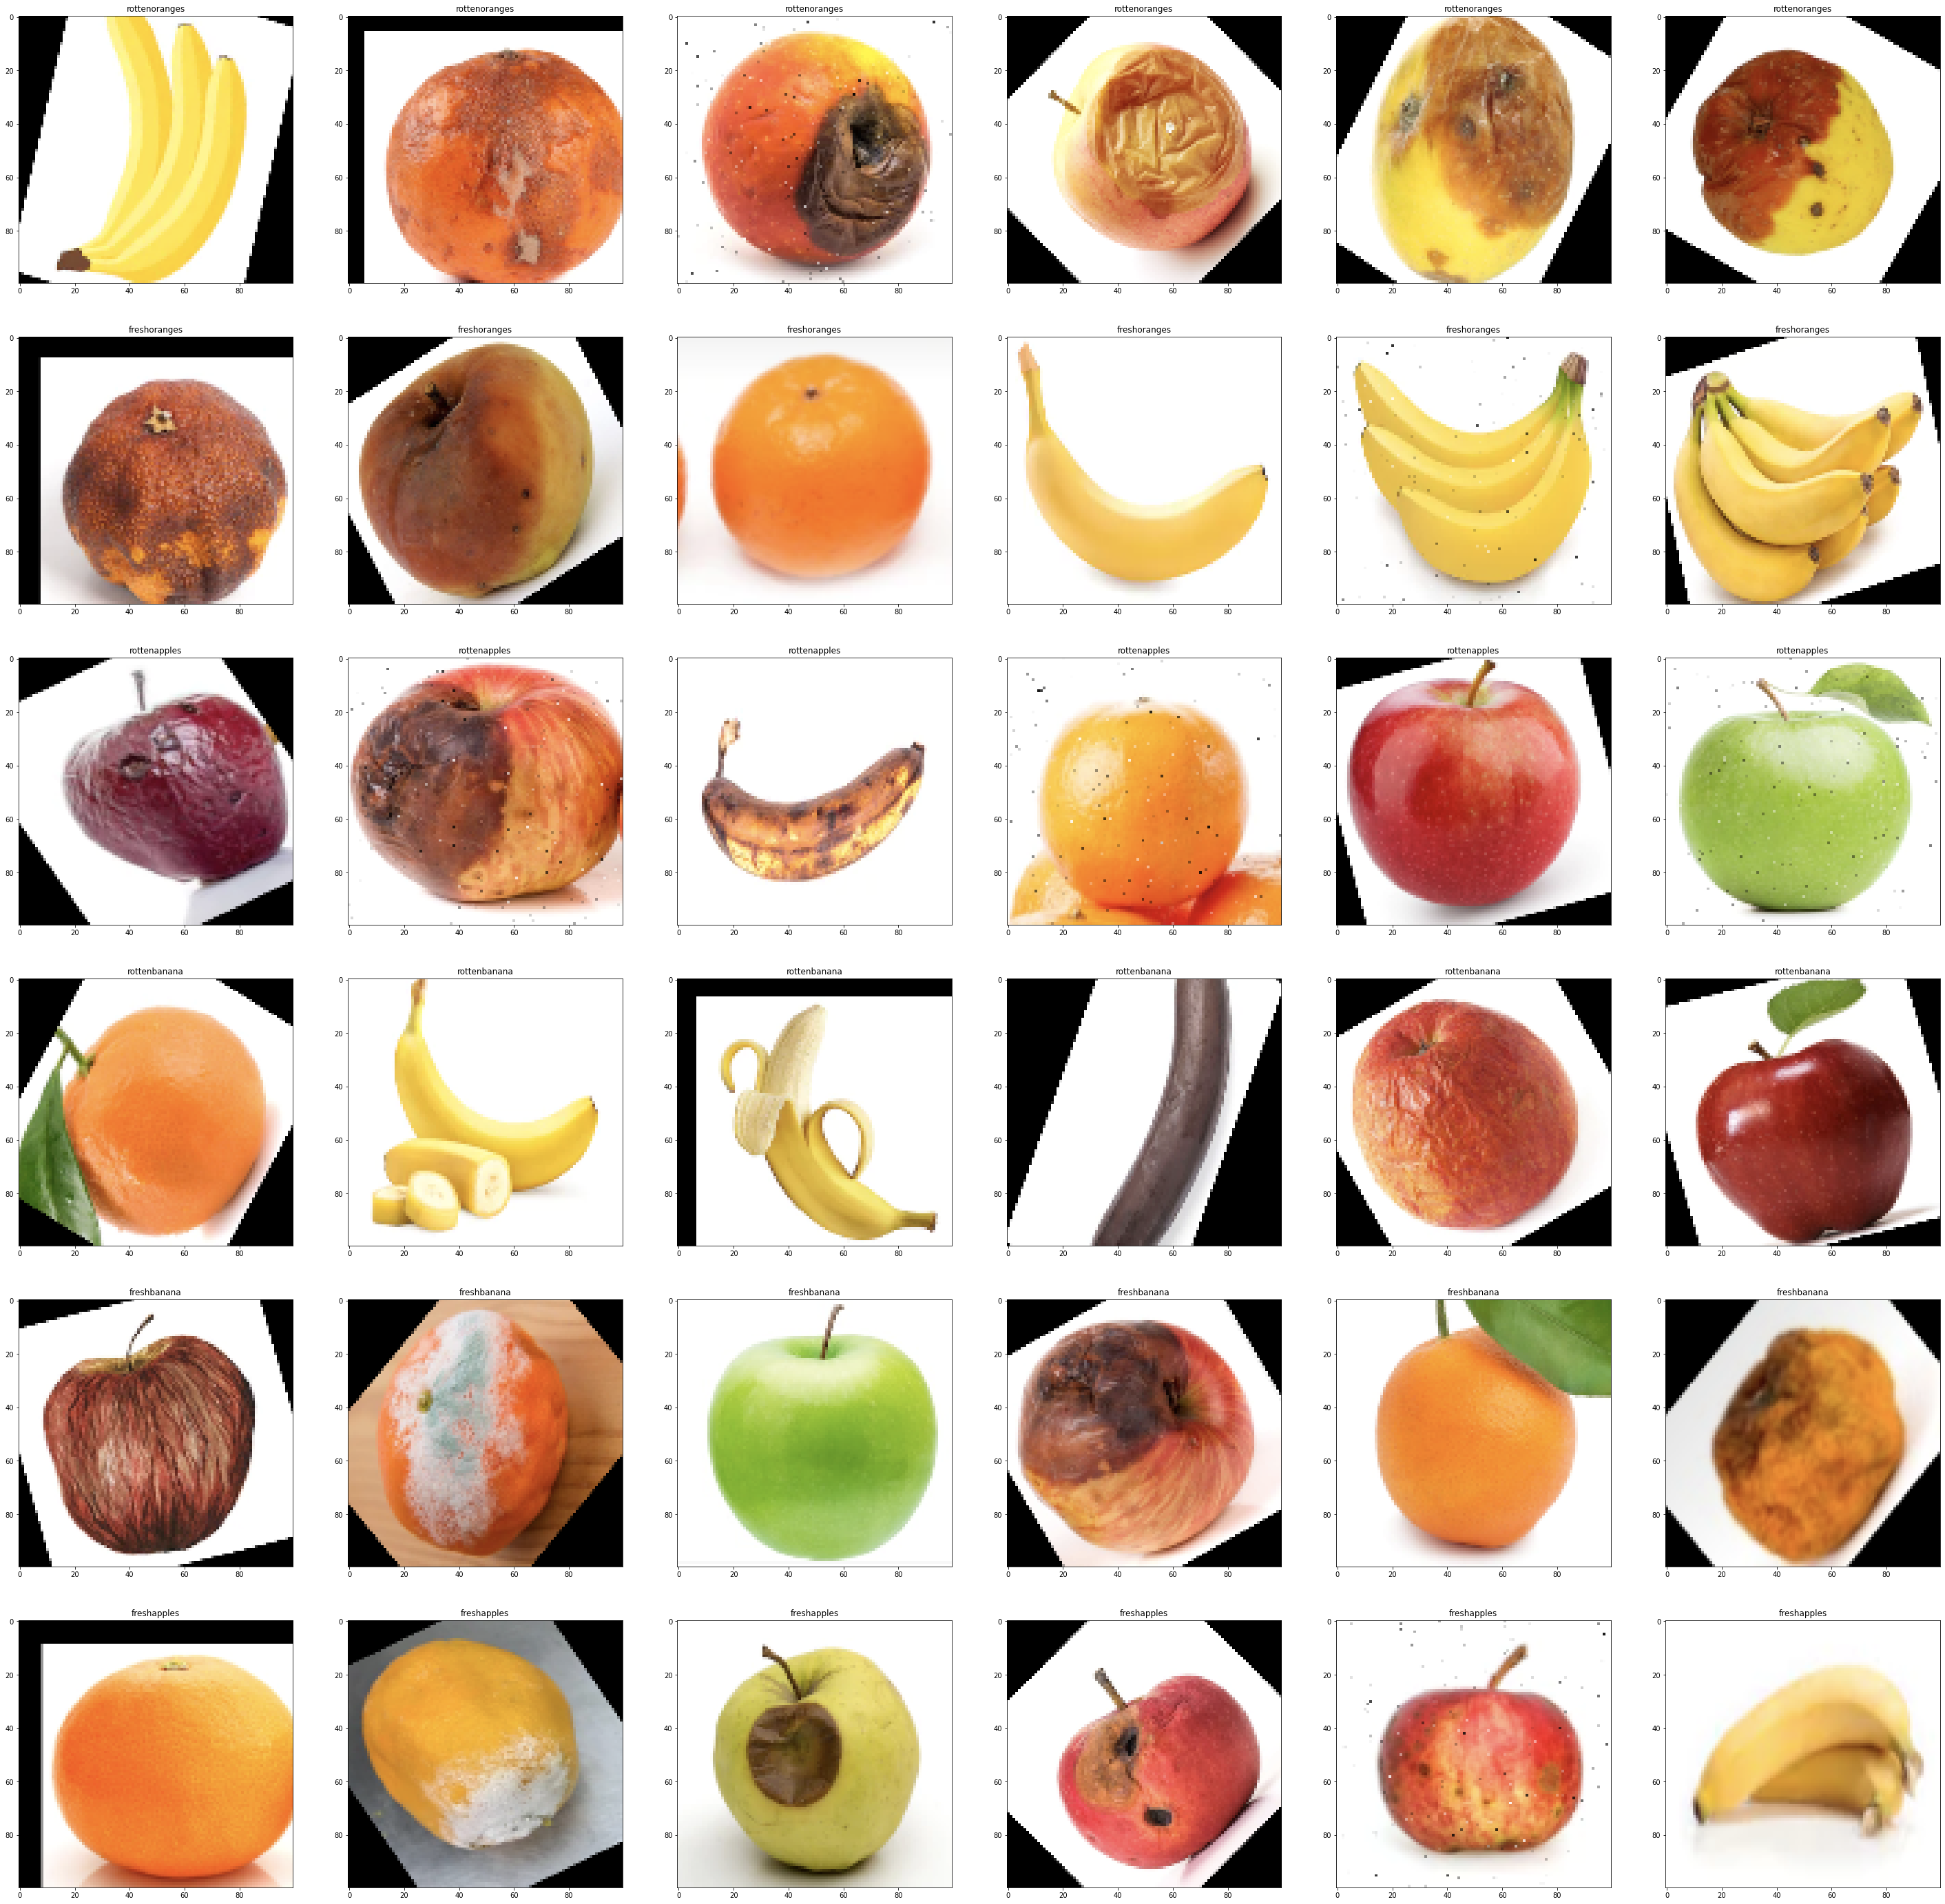

In [38]:
show_subpot(X_val[-36*11:-36*10])

In [39]:
model.predict_classes(X_val[-36*11:-36*10])

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)